In [413]:
%load_ext autoreload
%autoreload 2
%run Functions.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [414]:
%pylab inline
import bq
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [415]:
import seaborn as s
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,10)
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['savefig.facecolor'] = (1,1,1,1)
rcParams['savefig.dpi'] = 100

In [416]:
# Masses
mp = 0.9382
md = 1.8756 

In [417]:
def plot_matrix(frame, xInf=None,yInf=None,xSup=None,ySup=None, **args):
    from matplotlib.colors import LogNorm
    x,y = np.meshgrid(np.array(frame.index,   dtype=float),
                      np.array(frame.columns, dtype=float))
    z = frame.T.values.astype(float)
    ret = gca().pcolor(y,x,z, **args)
    if xInf is None:
        xInf=frame.columns[0]
    if xSup is None:
        xSup=frame.columns[-1]
    if yInf is None:
        yInf=frame.index[0]
    if ySup is None:
        ySup=frame.index[-1]
        
    
    xlim(xInf,xSup)
    ylim(yInf,ySup)
    
    return ret

In [418]:
client = bq.Client.Get()

In [419]:
from histQueryFactory import *

In [420]:
schema = client.GetTableSchema({
    'projectId': 'ams-test-kostya', 
    'datasetId': 'AMS',  
    'tableId': 'protonsB1034'
})

bitFields = None
for field in schema['fields']:
    if field['name'] != 'selStatus': 
        continue
    bitFields = field['description'].split(',')
    break
    
get_cumulative_mask = lambda sel: (1 << (bitFields.index(sel))) - 1

In [431]:
def build_frames(frames, table):
    for v in[ ("1/R",0,2,100, "invR"),
              ("EdepTRD",0,200,200, "EdepTRD"), 
              ("EdepTRD/NTRDclusters",0,30,200, "EdepTRDPerCluster"), 
              ("EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3",0,40,100, "EdepTOF"),
              ("EdepTrack",0,1000,100, "EdepTrack") 
            ]:
        h = HistQueryFactory(table=table)
        h.add_variable(*v)
        h.add_variable("1/BetaTOF",0.5,2.0,100, 'ib')

        #h.add_condition("selStatus&{0}={0}".format(get_cumulative_mask('aRing')))
        h.add_condition("unusedLayers==0")

        tableid = client.Query(str(h))['configuration']['query']['destinationTable']
        bq_table = client.ReadTableRows(tableid)

        frames[v[-1]] = pd.DataFrame(bq_table, columns=h.get_variables()+['Counts']).astype(float)

def plot_frames(frames):
    from matplotlib.colors import LogNorm
    s.set(rc={'image.cmap': "jet"})
    for n, k in enumerate(frames):
        subplot(2,2,n+1,)
        frame = frames[k]
        frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
        frame /= frame.sum(axis=0)
        plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
        xlabel("1/BetaTOF")
        ylabel(k)

In [432]:
framesMC, framesData = {}, {}
build_frames(framesMC,   "AMS.protonsB1034")
build_frames(framesData, "AMS.Data")

Waiting on bqjob_r1e990124ddf856c5_0000014f6089ad38_82 ... (0s) Current status: DONE   
Waiting on bqjob_r756459cb08a3799_0000014f6089b50e_83 ... (0s) Current status: DONE   
Waiting on bqjob_r4091db026ea83689_0000014f6089bed5_84 ... (0s) Current status: DONE   
Waiting on bqjob_r7cf0b5d60b5885cc_0000014f6089ce68_85 ... (0s) Current status: DONE   
Waiting on bqjob_r7484a16cb49ce11a_0000014f6089d5ff_86 ... (0s) Current status: DONE   
Waiting on bqjob_r35e28868855d7230_0000014f6089ddb7_87 ... (0s) Current status: DONE   
Waiting on bqjob_r59bb680c81603434_0000014f6089e654_88 ... (0s) Current status: DONE   
Waiting on bqjob_r123122f129d0a217_0000014f6089f0bb_89 ... (3s) Current status: DONE   
Waiting on bqjob_r32b955175ef82062_0000014f608a0c93_90 ... (0s) Current status: DONE   
Waiting on bqjob_r88d376832410def_0000014f608a1a41_91 ... (0s) Current status: DONE   


ValueError: num must be 0 <= num <= 4, not 5

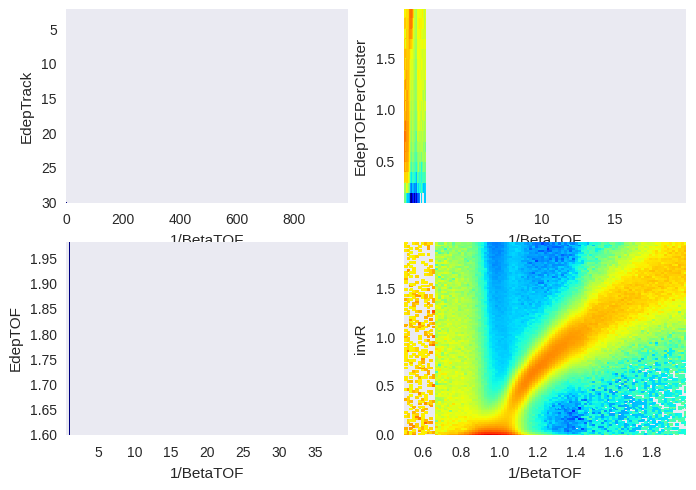

In [138]:
figsize(24,8)
plot_frames(framesMC)
tight_layout()

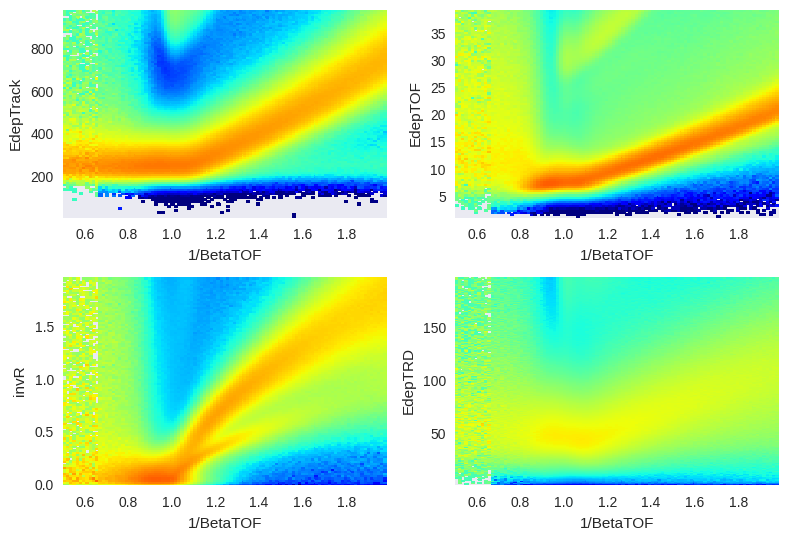

In [17]:
figsize(12,8)
plot_frames(framesData)
tight_layout()

In [22]:
frames = {}
for v in[
    ("1/R",0,2,100, "invR"),
    ("EdepTRD",0,200,200, "EdepTRD"), 
    ("EdepTOF_0+EdepTOF_1+EdepTOF_2+EdepTOF_3",0,40,100, "EdepTOF"),
    ("EdepTrack",0,1000,100, "EdepTrack")
]:

    print v
    h = HistQueryFactory(table=build_frames(framesMC, "AMS.protonsB1034"))
    h.add_variable(*v)
    h.add_variable("1/BetaTOF",0.5,2.0,100, 'ib')

    #h.add_condition("selStatus&{0}={0}".format(get_cumulative_mask('aRing')))
    h.add_condition("unusedLayers==0")

    tableid = client.Query(str(h))['configuration']['query']['destinationTable']
    bq_table = client.ReadTableRows(tableid)

    frames[v[-1]] = pd.DataFrame(bq_table, columns=h.get_variables()+['Counts']).astype(float)

('1/R', 0, 2, 100, 'invR')
Waiting on bqjob_r19e133d0f9803e94_0000014f5f430a0f_24 ... (0s) Current status: DONE   
Waiting on bqjob_r29175a2dd5d44cb5_0000014f5f431474_25 ... (0s) Current status: DONE   
Waiting on bqjob_r53eddd1643e54142_0000014f5f432106_26 ... (0s) Current status: DONE   
Waiting on bqjob_r1d8f5f1c83a82e8b_0000014f5f432c61_27 ... (0s) Current status: DONE   


BigqueryServiceError: Error processing job 'ams-test-kostya:bqjob_r4971530766cc13a2_0000014f5f43372c_28': Table name cannot be resolved: dataset name is missing.

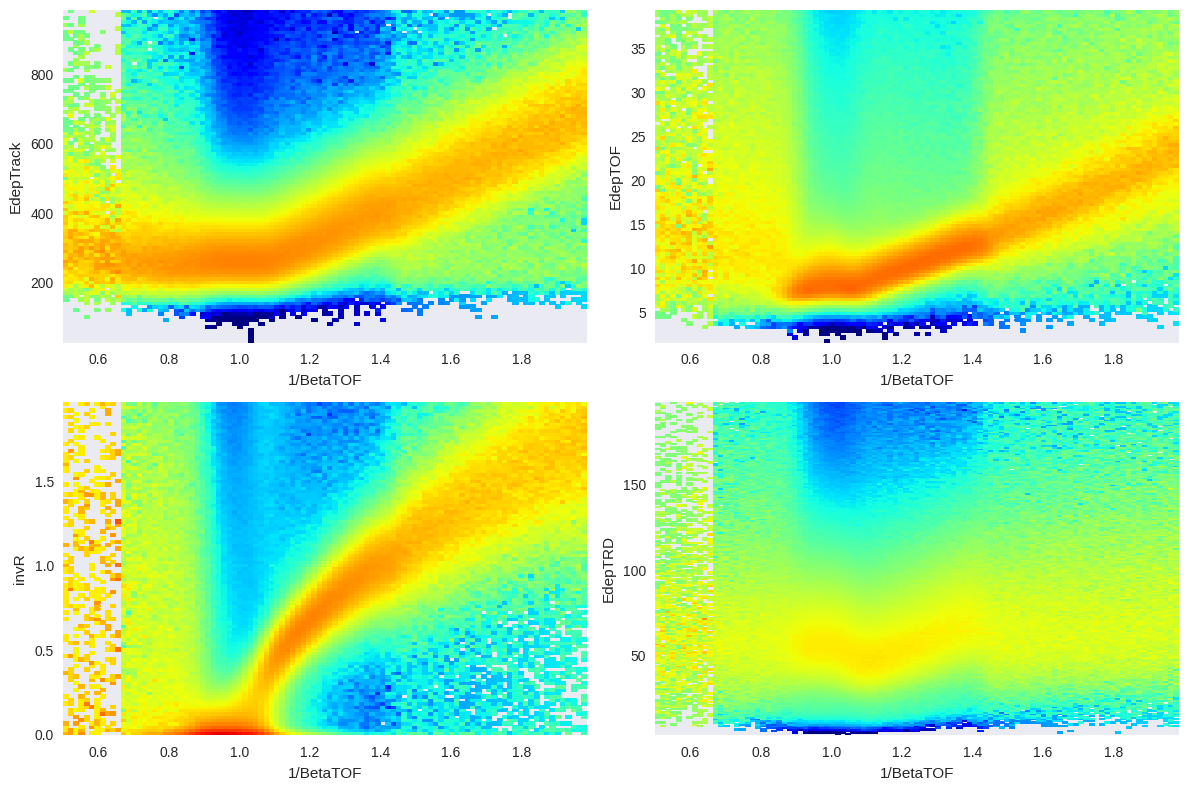

In [24]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,8)

for n, k in enumerate(framesMC):
    subplot(2,2,n+1,)
    frame = framesMC[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

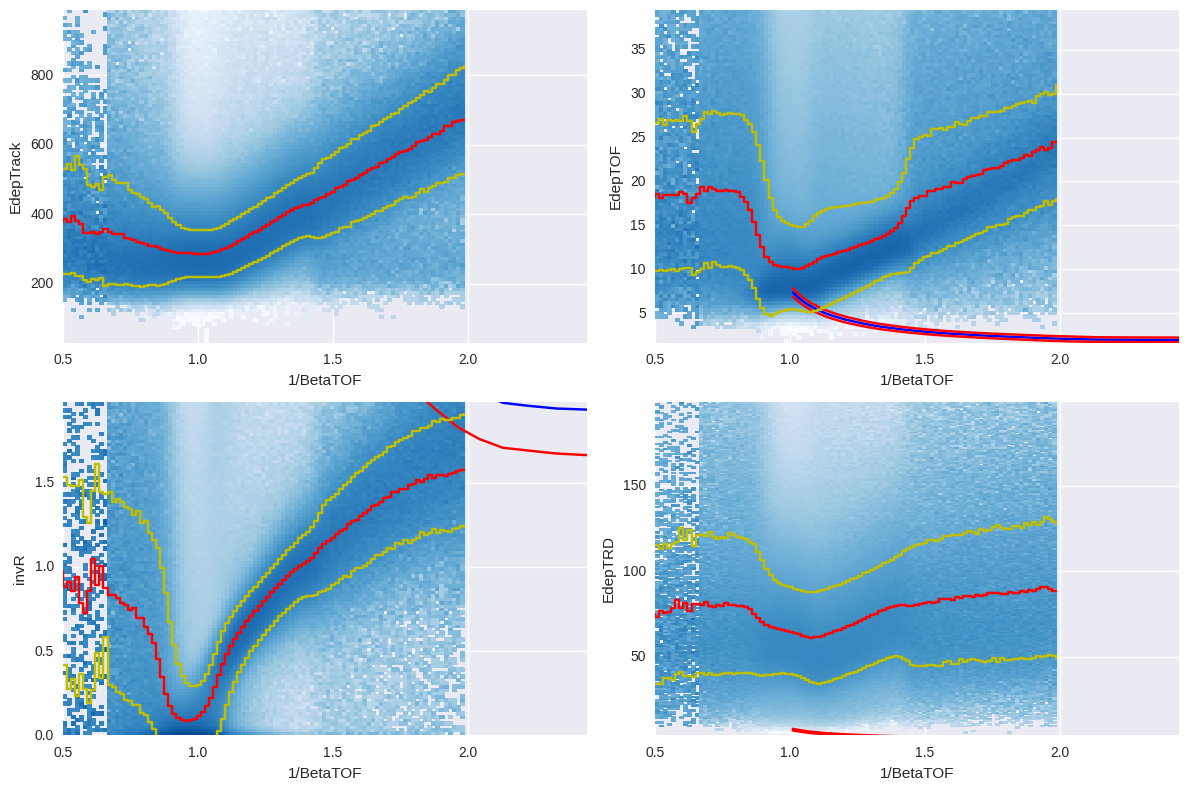

In [44]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "Blues"})
figsize(12,8)

for n, k in enumerate(framesMC):
    subplot(2,2,n+1,)
    frame = framesMC[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    
    invBetaCent=1/Beta_cent[::-1]
    plot(invBetaCent,ETOF,'b')
    plot(invBetaCent,ETOF+sigmaEtofinv*(ETOF**2),'r')
    plot(invBetaCent,ETOF-sigmaEtofinv*(ETOF**2),'r')
    
    mean = frame.mul(pd.Series(frame.index,frame.index), axis=0).sum(axis=0)
    std = frame.mul((pd.Series(frame.index,frame.index))**2, axis=0).sum(axis=0)
    std = np.sqrt((std-mean**2))
    
       
    mean.plot(style='r', drawstyle='steps')   
    (mean+std).plot(style='y', drawstyle='steps-post')
    (mean-std).plot(style='y', drawstyle='steps-post')
    
    xlabel("1/BetaTOF")
    ylabel(k)
    
tight_layout()

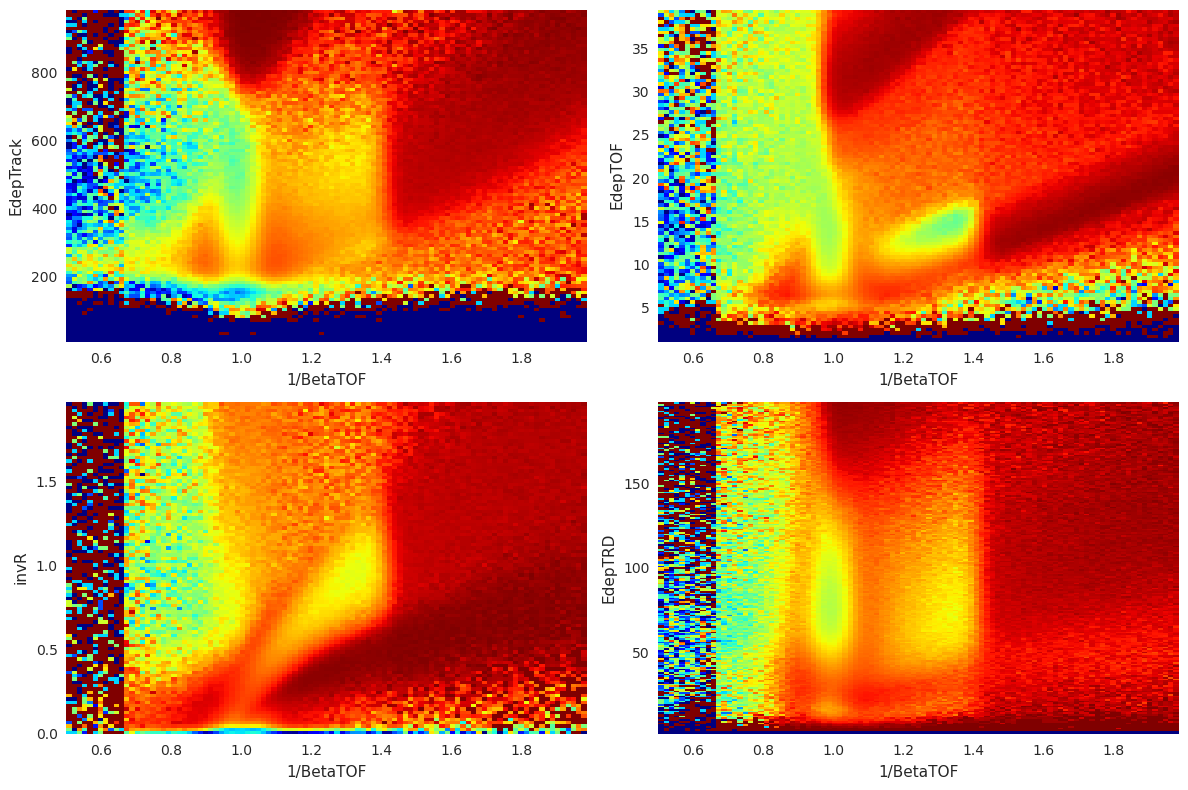

In [42]:
from matplotlib.colors import LogNorm
s.set(rc={'image.cmap': "jet"})
figsize(12,8)

for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    frame = frames[k]
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    #frame /= frame.sum(axis=0)
    frameMC = framesMC[k]
    frameMC = frameMC.set_index(list(frameMC.columns[:-1])).unstack().fillna(0)['Counts']
    #frameMC /= frameMC.sum(axis=0)

    
    plot_matrix((np.abs(frame-frameMC)/(frame+frameMC)).fillna(0))#, norm=LogNorm(vmin=10**(-5),vmax=100))
    xlabel("1/BetaTOF")
    ylabel(k)

tight_layout()

# Fitting the profile of all Edep by gaussians

In [392]:
from scipy.optimize import leastsq

def fitGaussianPerXSlice(frame,key):
    inverseBetaBin=np.unique(frame['ib'])

    gausParam=[]

    for bin in inverseBetaBin:
        df=frame[frame['ib']==bin]

        fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)
        errfunc  = lambda p, x, y: (y - fitfunc(p, x))

        mean=np.average(df[key], weights=df.Counts)
        std=np.average((df[key]-mean)**2,weights=df.Counts)
        std=math.sqrt(std)
        init  = [df['Counts'].max(),
                 mean,
                 std]
        
        out   = leastsq( errfunc, init, args=(df[key], df['Counts']))
        gausParam.append(out[0])

    gausParam=np.array(gausParam[::])
    return gausParam

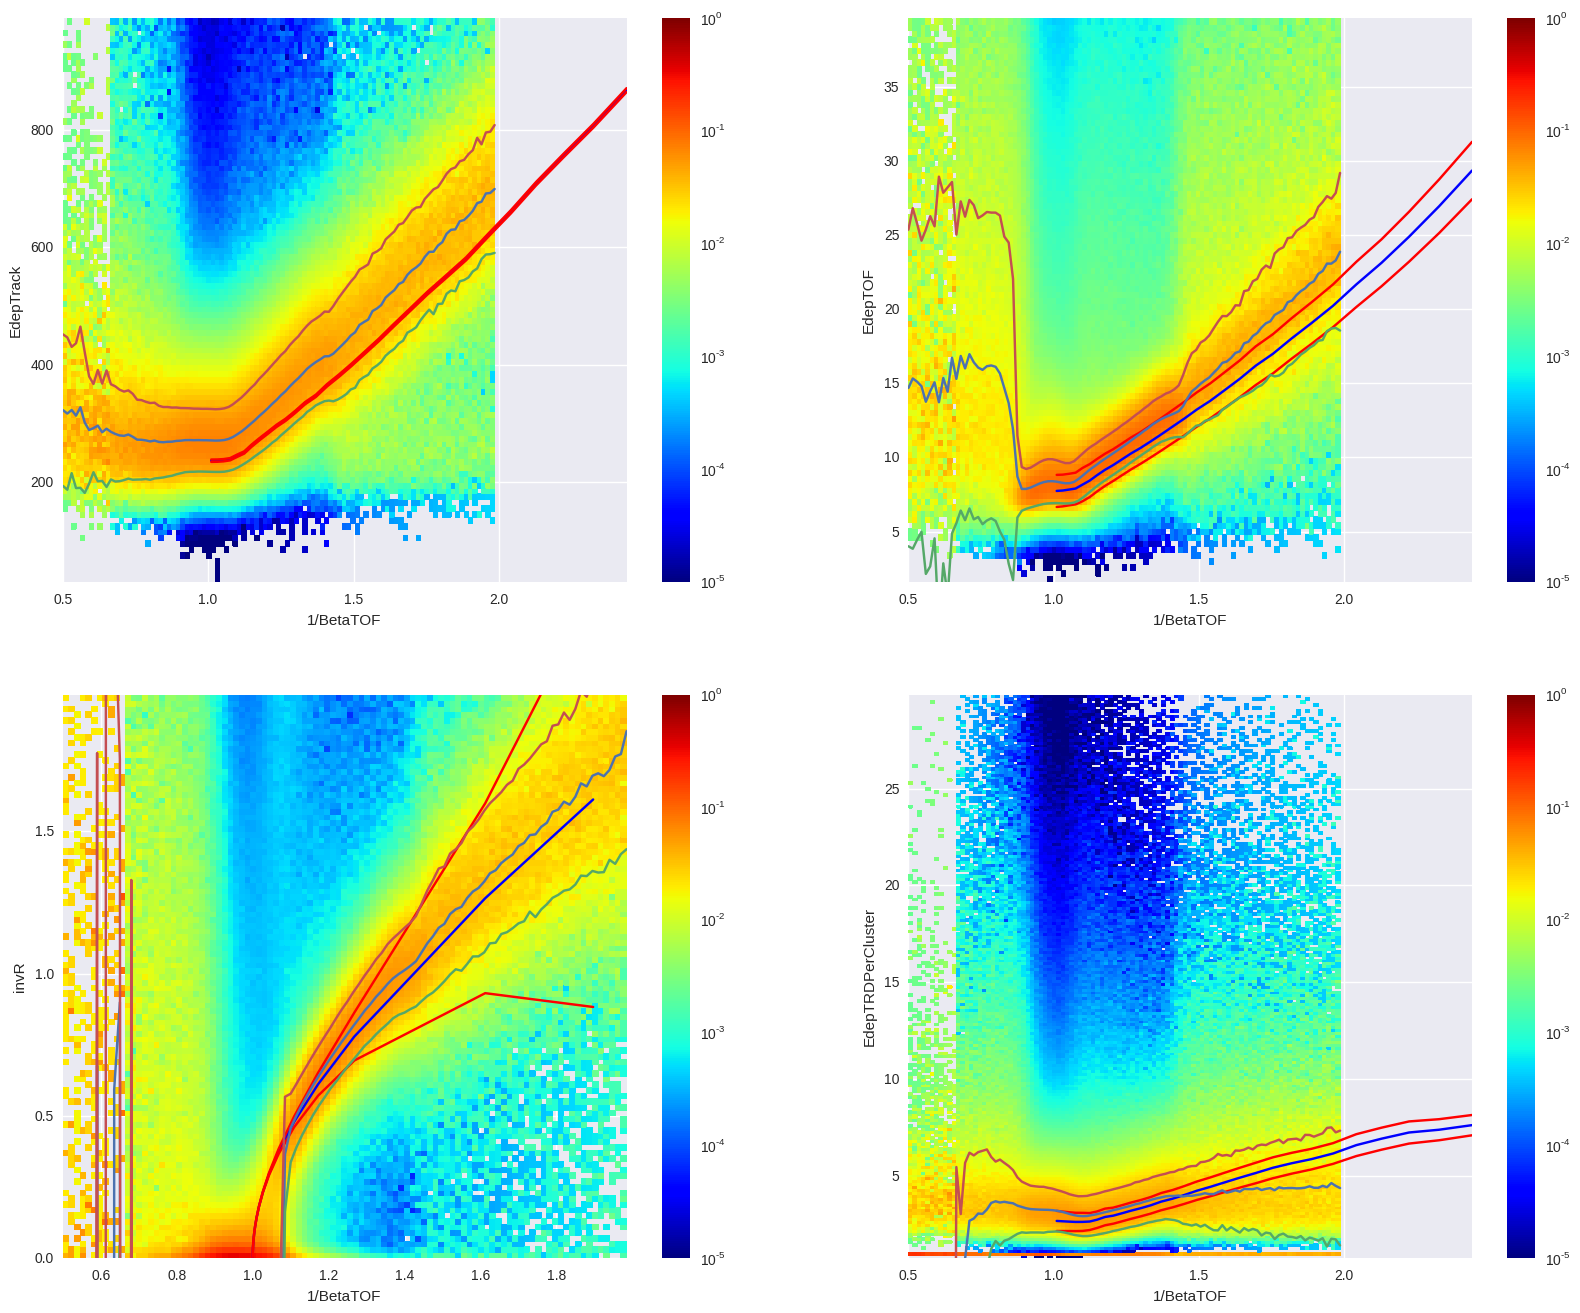

In [433]:
# s.set(rc={'image.cmap': "jet"})

frames = {key: framesMC[key] for key in framesMC if key in ['EdepTrack','EdepTOF','EdepTRDPerCluster','invR'] }
figsize(20,16)
# frames = {key: framesMC[key] for key in framesMC if key in ['invR'] }

def plotFrancescoEnveloppes(axes):
    xAxis,mean,sigma = axes
    plot(xAxis,mean,'b')
    plot(xAxis,mean+sigma*(mean**2),'r')
    plot(xAxis,mean-sigma*(mean**2),'r')
    
francescoAxes=dict()
francescoAxes['EdepTrack']=[1/betaTrueArray[::-1],
                                    ETrack[::-1]*2000,
                                    sigmaEtofinv[::-1]/2000]
francescoAxes['EdepTOF']=[1/betaTrueArray[::-1],
                                    ETOF[::-1]*4,
                                    sigmaEtofinv[::-1]/4]
francescoAxes['EdepTRDPerCluster']=[  1/betaTrueArray[::-1],
                            ETRD[::-1],
                            sigmaEtofinv[::-1]]
m=1
francescoAxes['invR']=[  (np.sqrt(m**2+rgdtTrueArray**2)/rgdtTrueArray)[::-1],
                            1/rgdtTrueArray[::-1],
                             sigmaRinv[::-1]]
                                    
    
for n, k in enumerate(frames):
    subplot(2,2,n+1,)
    
    frame = frames[k]
    gaussian=fitGaussianPerXSlice(frame,k)
    frame = frame.set_index(list(frame.columns[:-1])).unstack().fillna(0)['Counts']
    frame /= frame.sum(axis=0)
    fig=plot_matrix(frame, norm=LogNorm(vmin=10**(-5),vmax=1))
    colorbar(fig)
    
    plotFrancescoEnveloppes(francescoAxes[k])

    mean = pd.Series(gaussian.T[1],frame.columns.values)
    sigmaAboveMean = pd.Series(gaussian.T[1] + gaussian.T[2],frame.columns.values)
    sigmaBelowMean = pd.Series(gaussian.T[1] - gaussian.T[2],frame.columns.values)
    
    mean.plot()
    sigmaBelowMean.plot()
    sigmaAboveMean.plot()
    
    xlabel("1/BetaTOF")
    ylabel(k)
    
